# Attention-based Models: the Vision Transformer (ViT)

This notebook presents a short tutorial on Attention and the Vision Transformer.

Adapted from: https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632 and https://d2l.ai/chapter_attention-mechanisms/

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

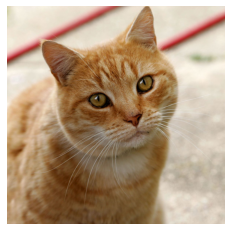

In [ ]:
img = Image.open('cat.jpg')

fig = plt.figure()
plt.axis('off')
plt.imshow(img)

In [ ]:
# resize to imagenet size 
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # add batch dim
x.shape

torch.Size([1, 3, 224, 224])

## Einops

einops is a flexible and powerful tensor operations package for readable and reliable code. Supports numpy, pytorch, tensorflow, and others.
https://github.com/arogozhnikov/einops

In [ ]:
# transform in a (batch x 1D) vector
# any labels can be used
y = rearrange(x, 'b c h w -> b (c h w)')
print(y.shape)

torch.Size([1, 150528])


## Attention


*   Natural visual scenes are cluttered and contain many different objects that cannot be processed simultaneously by a biological system.
*   Amount of information coming down the optic nerve far exceeds what the brain is capable of processing...
*   Throughout human history, we developed the capability of directing attention to only a fraction of information of interest, thus enabling our brain to allocate resources more smartly to survive, to grow, and to socialize, such as detecting predators, preys, and mates.


**Attention = nonvolitional + volitional cues**

**Nonvolitional Cues:** based on the saliency and conspicuity of objects in the environment. A red mug mixed with a set of black books will be intrinsically salient and conspicuos, automatically and involuntarily drawing attention.

**Volitional Cues:** Imagine you want to read a book. You turn your head, refocus your eyes, and look at the book. Different from the previous case where the red mug biases you towards selecting based on saliency, in this task-dependent case you select the book under cognitive and volitional control. Using the volitional cue based on variable selection criteria, this form of attention is more deliberate. It is also more powerful with the subject’s voluntary effort.

### Learnable attention: queries, keys and values

If we consider a simple case in which only **nonvolitional cues** are available, to bias selection over sensory inputs, we can simply use a parameterized fully-connected layer or even non-parameterized max or average pooling.

Attention mechanisms differ from those fully-connected layers or pooling layers is the inclusion of the **volitional cues**. 

qkv.svg


In the context of attention mechanisms, we refer to volitional cues as queries. Given any query, attention mechanisms bias selection over sensory inputs (e.g., intermediate feature representations) via attention pooling. These sensory inputs are called values in the context of attention mechanisms. More generally, every value is paired with a key, which can be thought of the nonvolitional cue of that sensory input. As shown, we can design attention pooling so that the given query (volitional cue) can interact with keys (nonvolitional cues), which guides bias selection over values (sensory inputs).

attention-output.svg


Given an attention scoring function, the output of attention pooling can be computed as a weighted sum of values. Since attention weights are a probability distribution, the weighted sum is essentially a weighted average.


### Additive attention

In general, when queries and keys are vectors of different lengths, we can use additive attention as the scoring function. Given a query q and a key k, the additive attention scoring function is given as follows:

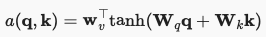

where Wq and Wk are the learnable parameters.

The query and the key are concatenated and fed into an MLP with a single hidden layer whose number of hidden units is h, a hyperparameter. tanh is used as the activation function and bias terms are disabled.

### Scaled dot product attention

A more computationally efficient design for the scoring function can be simply the dot product. However, the dot product operation requires that both the query and the key have the same vector length, say d.

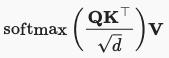

The division by the square root of d ensures unit variance.


### Multi-head attention

Given the same set of queries, keys, and values we may want our model to expand its ability to focus on different positions and learn multiple representation subspaces of the queries, keys, and values.

Instead of performing a single attention pooling, queries, keys, and values can be transformed with h independently learned linear projections. Then these  h projected queries, keys, and values are fed into attention pooling in parallel.In the end, h attention pooling outputs are concatenated and transformed with another learned linear projection to produce the final output. This is called **multi-head attention**, where each of the h attention pooling outputs is a head [Vaswani et al., 2017].

multi-head-attention.svg




## Transformer architecture

Originally proposed by [Vaswani et al., 2017] in their paper "Attention Is All You Need", the Transformer encompasses an encoder and a decoder module to perform machine translation.

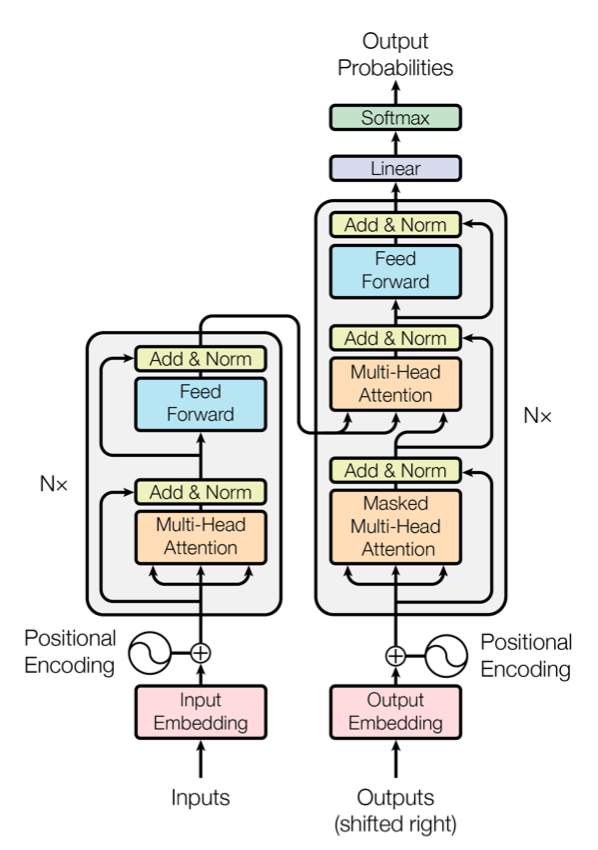


## Vision Transformer (ViT)

The Vision Transformer (ViT), proposed by [Dosovitskiy et al., 2021] in the paper "AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE", uses a Transformer Encoder block and divides the image into patches.

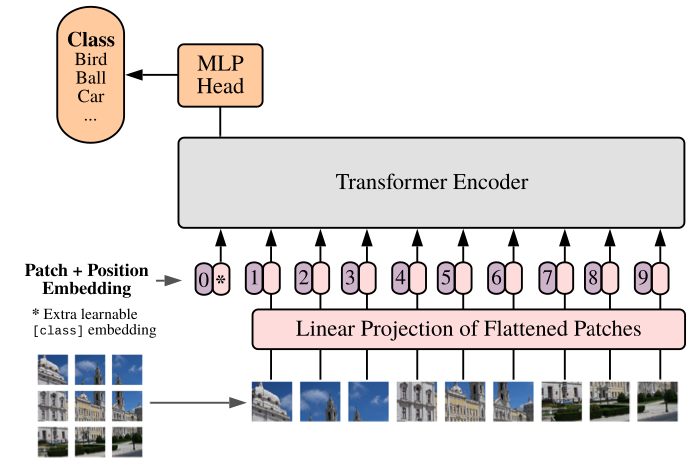

### Patch embedding

The input of the Transformer is a set of patches of the original image.



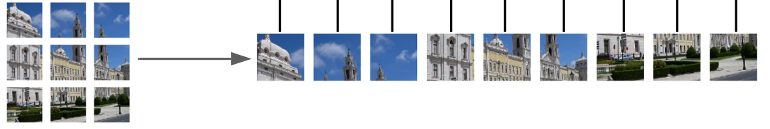

In [ ]:
patch_size = 16 # 16 pixels
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
patches.shape

torch.Size([1, 196, 768])

Then, each patch is projected using a linear layer.

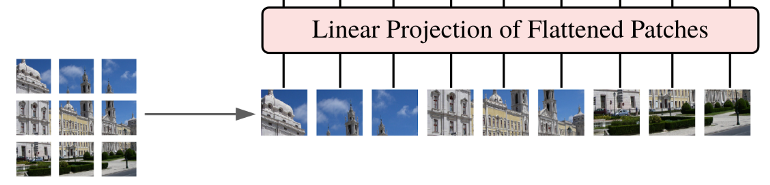

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # alternative 1
            # break-down the image in s1 x s2 patches and flat them
            # Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            # nn.Linear(patch_size * patch_size * in_channels, emb_size)

            # alternative 2
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
                
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

### Class token

The embedding also needs to include the CLS token - it is just a number placed in front of each sequence (of projected patches). This token will constitute a representation of the whole input.


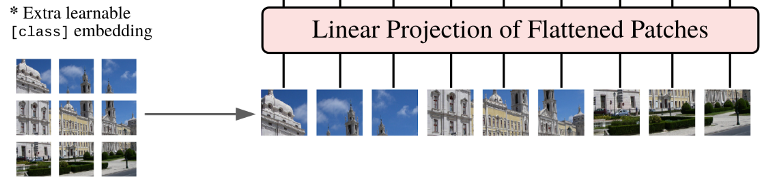

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))     ### <<< added
        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)

        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)   ### <<< added
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

### Position embedding

So far, the model has no idea about the original position of the patches. We need to pass this spatial information. This can be done in different ways, in ViT we let the model learn it. The position embedding is just a tensor of shape (N_PATCHES + 1, EMBED_SIZE) that is added to the projected patches.

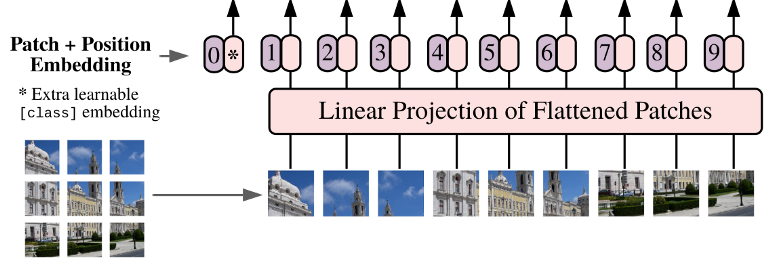

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))  ### <<< added

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        
        # add position embedding
        x += self.positions         ### <<< added
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

### Transformer encoder

#### Multi-head attention

The attention takes three inputs (queries, keys, and values) and computes the attention matrix using queries and keys, which, in turn, is used to “attend” to the values. In this case, we are using multi-head attention meaning that the computation is split across n heads with smaller input size.

The product between the queries and the keys is used to know “how much” each element in the sequence is important. Then, we use this information to scale the values.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.Wk = nn.Linear(emb_size, emb_size)
        self.Wq = nn.Linear(emb_size, emb_size)
        self.Wv = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        queries = rearrange(self.Wq(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.Wk(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.Wv(x), "b n (h d) -> b h n d", h=self.num_heads)
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768])

#### Residuals

The transformer block has residuals connection.

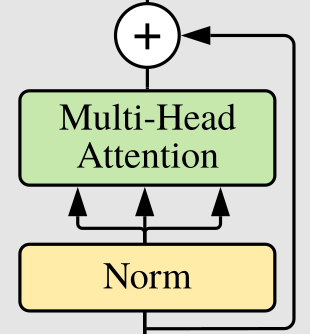

In [ ]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

#### MLP

The attention’s output is passed to a fully connected layer composed of two layers that upsample by a factor of expansion the input.

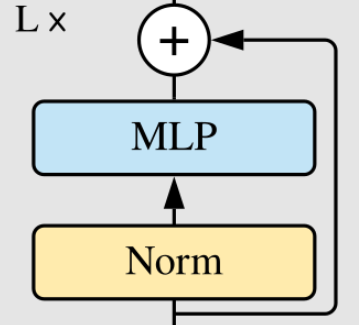

In [ ]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

The feedforward block uses a Gaussian Error Linear Unit (GELU) activation layer, which weights inputs by their percentile, rather than gates inputs by their sign as in ReLUs. Consequently the GELU can be thought of as a smoother ReLU.

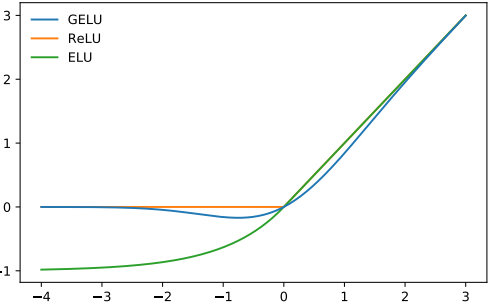

#### Complete block

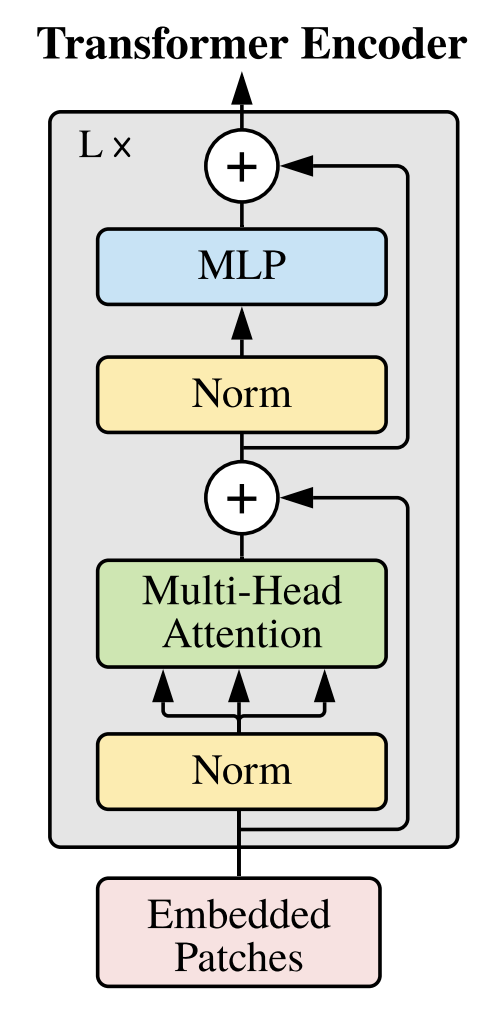

In [ ]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))
            
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])

### Putting it all together

The ViT encoder is simply a stack of L blocks of TransformerBlock.

The last layer is a normal fully connected layer that computes the class probability. It first performs a basic mean (average pooling) over the whole sequence.

In [ ]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 5, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            ## this implementation uses average pooling of the output hidden states of all input tokens,
            ## but the original implementation just used the CLS token hidden state
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 5,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [ ]:
summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5             [-1, 197, 768]         590,592
            Linear-6             [-1, 197, 768]         590,592
            Linear-7             [-1, 197, 768]         590,592
           Dropout-8          [-1, 8, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
MultiHeadAttention-10             [-1, 197, 768]               0
          Dropout-11             [-1, 197, 768]               0
      ResidualAdd-12             [-1, 197, 768]               0
        LayerNorm-13             [-1, 197, 768]           1,536
           Linear-14            [-1, 1